juliette.jin

# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

Check the installation by running the following cell

In [2]:
import monai
monai.config.print_config()

2024-10-16 21:25:33.347199: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 21:25:33.435211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 21:25:33.471024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 21:25:33.482165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 21:25:33.544449: I tensorflow/core/platform/cpu_feature_guar

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/anaconda3/envs/mlbio/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.17.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.1+cu121
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd ver

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

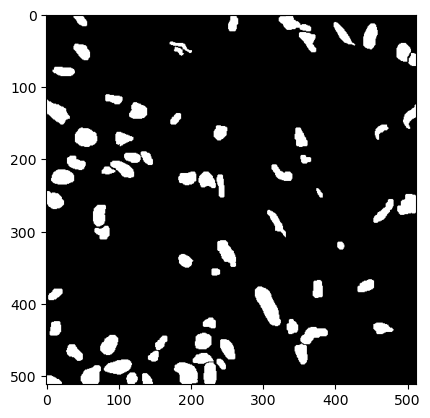

In [8]:
import matplotlib.pyplot as plt

path = 'TNBC_NucleiSegmentation/GT_01/01_1.png'
img = plt.imread(path)
plt.imshow(img, cmap='gray')
plt.show()

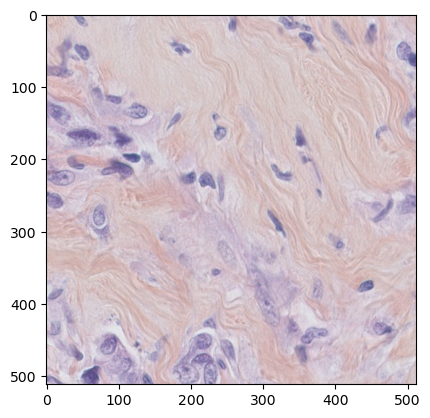

In [10]:
path2 = 'TNBC_NucleiSegmentation/Slide_01/01_1.png'
img2 = plt.imread(path2)
plt.imshow(img2, cmap='gray')
plt.show()

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [17]:
from grpc import Channel
import torch

from monai.transforms import Compose, LoadImage, ToTensor, EnsureChannelFirst, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [18]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(label_files[index])



By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [ ]:
train_loader = torch.utils.data.DataLoader()
test_loader = 

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [ ]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




With torch.optim, define an optimizer for your model. Use the Adam optimiser



# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [ ]:
epoch_loss_values = list()
for epoch in range(2):

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions =

        # compute the loss using the loss function, the predictions and labels
        loss =

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


Display the prediction of your model on several image

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model